In [2]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
from copy import copy
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle

In [3]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods_tags = {}
# fs_methods_tags = {
#     "lasso1_nocluster": "Lasso",
#     "pairwise-granger_nocluster": "Pairwise Granger",
#     "multivariate-granger_nocluster": "Multivariate Granger",
#     "dynotears_rollingcluster_k5": "Dynotears",
#     "var-lingam_rollingcluster_k5": "VAR-LiNGAM",

# }

fs_methods = [
    # "sfstscv-lin_nocluster",
    # "sfstscv-rf_rollingkmeans_k5_rank",
    # "sfstscv-rf_rollingkmeans_k10_rank",
    # "dynotears_nocluster",
    # "dynotears_rollingkmeans_k5_rank",
    # "dynotears_rollingkmeans_k10_rank",
    "multivariate-granger_rollingkmeans_k5_rank",
    "multivariate-granger_rollingkmeans_k10_rank",
    "pairwise-granger_nocluster",
    "var-lingam_rollingkmeans_k5_rank",
    "var-lingam_rollingkmeans_k10_rank",
    ]

etfs = [
    "SPY"
]

event_dates = [
    ("GFC", ("2007-07-01", "2008-11-01")),
    ("Dow Jones Flash Crash", ("2010-03-01", "2010-07-01")),
    ("Tsunami Fukushima", ("2011-01-01", "2011-05-01")),
    ("Black Monday 2011", ("2011-06-01", "2011-10-01")),
    ("Chinese Black Monday", ("2015-06-01", "2015-10-01")),
    ("Dow Jones Plunge 2018", ("2018-01-01", "2018-05-01")),
    ("COVID-19", ("2020-01-01", "2020-05-01"))
]

metric_names = ["mse", "mae", "rmse", "mse_crisis", "mae_crisis", "rmse_crisis"]
etf_focus = None
stability_threshold = 0.8   
plot_ts = False

In [4]:
warnings.simplefilter("ignore")

all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    if len(results_files) == 0:
        raise Exception(f"No results files found for {fs}")

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if etf not in etfs:
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions'].loc["2006-01-01":]

        # filter predictions
        predictions_df.loc[(predictions_df['prediction_zscore'] == 1)|(predictions_df['prediction_zscore'] == -1), 'prediction_zscore'] = 0
        predictions_df.loc[(predictions_df['prediction'] == 1)|(predictions_df['prediction'] == -1), 'prediction'] = 0
        
        # Dictionary to hold the data subsets for each event
        crisis_predictions = []

        # Loop through the event_dates list, subset the DataFrame, and store each subset in the dictionary
        for event_name, (start_date, end_date) in event_dates:
            # Subset the DataFrame within the specified date range
            subset_df = predictions_df.loc[start_date:end_date]
            # Store the subset DataFrame in the dictionary with the event name as the key
            crisis_predictions.append(subset_df)

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = ((rolling_metric_df["true"]  - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean()
        rolling_metric_df["rolling_mae"] = (abs(rolling_metric_df["true"] - rolling_metric_df["prediction"])).rolling(window=12).mean()
        rolling_metric_df["rolling_rmse"] = np.sqrt(((rolling_metric_df["true"] - rolling_metric_df["prediction"]) ** 2).rolling(window=12).mean())
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["diff", "rolling_mse", "rolling_mae", "rolling_rmse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100
        rmse = np.sqrt(mean_squared_error(predictions_df["true"], predictions_df["prediction"])) * 100

        crisis_predictions_df = pd.concat(crisis_predictions)
        crisis_mse = mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_mae = mean_absolute_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"]) * 100
        crisis_rmse = np.sqrt(mean_squared_error(crisis_predictions_df["true"], crisis_predictions_df["prediction"])) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # add tags
        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        # fill na of clusters column
        if "nocluster" in fs:
            parents_of_target_df['cluster'] = pd.factorize(parents_of_target_df['fred'])[0]
        elif ("pca" in fs):
            codes, uniques = pd.factorize(parents_of_target_df['fred'])
            parents_of_target_df['cluster'] = codes         
        else:
            parents_of_target_df["cluster"] = parents_of_target_df["cluster"].fillna(parents_of_target_df["cluster"].max() + 1)

        all_parents.append(parents_of_target_df)

        metrics_df = pd.DataFrame({
            "fs": fs_methods_tags[fs] if len(fs_methods_tags) > 0 else fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            "rmse": [rmse],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "rmse_crisis": [crisis_rmse]})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

In [6]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
   # "sfstscv-lin_nocluster",
    # "sfstscv-rf_rollingkmeans_k5_rank",
    # "sfstscv-rf_rollingkmeans_k10_rank",
    # "dynotears_nocluster",
    # "dynotears_rollingkmeans_k5_rank",
    # "dynotears_rollingkmeans_k10_rank",
    "multivariate-granger_rollingkmeans_k5_rank",
    "multivariate-granger_rollingkmeans_k10_rank",
    "pairwise-granger_nocluster",
    "var-lingam_rollingkmeans_k5_rank",
    "var-lingam_rollingkmeans_k10_rank",
]

rename_fs = {
    "sfstscv-lin_nocluster": "SFS-Linear",
    "dynotears_nocluster": "Dynotears",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "multivariate-granger_nocluster": "Multivariate Granger",
    "var-lingam_rollingkmeans_k5_rank": "Modified VAR-LiNGAM",
}

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    # etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["SFS-Linear minus Dynotears"] = etf_rolling_metrics_df["sfstscv-lin_nocluster"] - etf_rolling_metrics_df["dynotears_rollingkmeans_k5_rank"]
    etf_rolling_metrics_df = etf_rolling_metrics_df.rename(columns=rename_fs)

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["SFS-Linear minus Dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df["SFS-Linear minus Dynotears"].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

         # Check if the event is GFC and add text label
        if (event_name == "GFC") or (event_name == "COVID-19"):
            mid_point = pd.to_datetime(start_date) + (pd.to_datetime(end_date) - pd.to_datetime(start_date)) / 2
            axs[0].text(mid_point, axs[0].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)
            axs[1].text(mid_point, axs[1].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)


    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_rmse.png'))

    # Show the plot
    plt.show()

KeyError: 'sfstscv-lin_nocluster'

In [7]:
all_etfs_scores = []
all_avg_scores = []
for ticker in all_parents_df["etf"].unique():
    etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
    etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

    etf_df = etf_df.sort_values(by=["date"])
    all_scores = []
    for fs in etf_df["fs"].unique():
        fs_etf_df = etf_df[etf_df["fs"] == fs]

        score = []
        for i, date in enumerate(fs_etf_df["date"].unique()):
            if i == 0:
                F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = 0
            else:
                F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
                s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
                F_tm1 = copy(F_t)
            score.append({"date": date, "score": s})
        score_df = pd.DataFrame(score)
        score_df["fs"] = fs

        melt_score_df = score_df.melt(["date", "fs"])
        all_scores.append(melt_score_df)
    all_scores_df = pd.concat(all_scores).drop("variable", axis=1)
    all_scores_df["etf"] = ticker
    all_etfs_scores.append(all_scores_df)

    avg_scores = all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False).reset_index()
    avg_scores['ticker'] = ticker
    avg_scores = avg_scores[['ticker', 'fs', 'value']]
    all_avg_scores.append(avg_scores)
all_avg_scores_df = pd.concat(all_avg_scores)
all_etfs_scores_df = pd.concat(all_etfs_scores)

## Table with the summary statistics

In [8]:
melted_all_metrics_df.pivot_table(index=["fs"], columns=["variable"], values="value").round(2)

variable,mae,mae_crisis,mse,mse_crisis,rmse,rmse_crisis
fs,,,,,,
multivariate-granger_rollingkmeans_k10_rank,3.59,4.37,0.24,0.34,4.93,5.79
multivariate-granger_rollingkmeans_k5_rank,3.57,4.40,0.24,0.34,4.90,5.80
pairwise-granger_nocluster,3.62,4.46,0.24,0.32,4.87,5.69
var-lingam_rollingkmeans_k10_rank,3.49,4.38,0.21,0.34,4.54,5.84
var-lingam_rollingkmeans_k5_rank,3.49,4.38,0.21,0.34,4.53,5.84


In [9]:
pivot_all_metrics_df = melted_all_metrics_df.pivot_table(index=["fs"], columns=["variable"], values="value")

# compute diffference between crisis and non-crisis
pivot_all_metrics_df["diff_mse"] = (pivot_all_metrics_df["mse_crisis"] / pivot_all_metrics_df["mse"] - 1) * 100
pivot_all_metrics_df["diff_mae"] = (pivot_all_metrics_df["mae_crisis"] / pivot_all_metrics_df["mae"] - 1) * 100
pivot_all_metrics_df["diff_rmse"] = (pivot_all_metrics_df["rmse_crisis"] / pivot_all_metrics_df["rmse"] - 1) * 100

pivot_all_metrics_df[["diff_mse", "diff_mae", "diff_rmse"]].round(2)

variable,diff_mse,diff_mae,diff_rmse
fs,,,
multivariate-granger_rollingkmeans_k10_rank,38.28,21.67,17.59
multivariate-granger_rollingkmeans_k5_rank,40.27,23.39,18.43
pairwise-granger_nocluster,36.11,23.26,16.67
var-lingam_rollingkmeans_k10_rank,65.73,25.30,28.74
var-lingam_rollingkmeans_k5_rank,66.22,25.41,28.93


## Boxplots with summary statistics

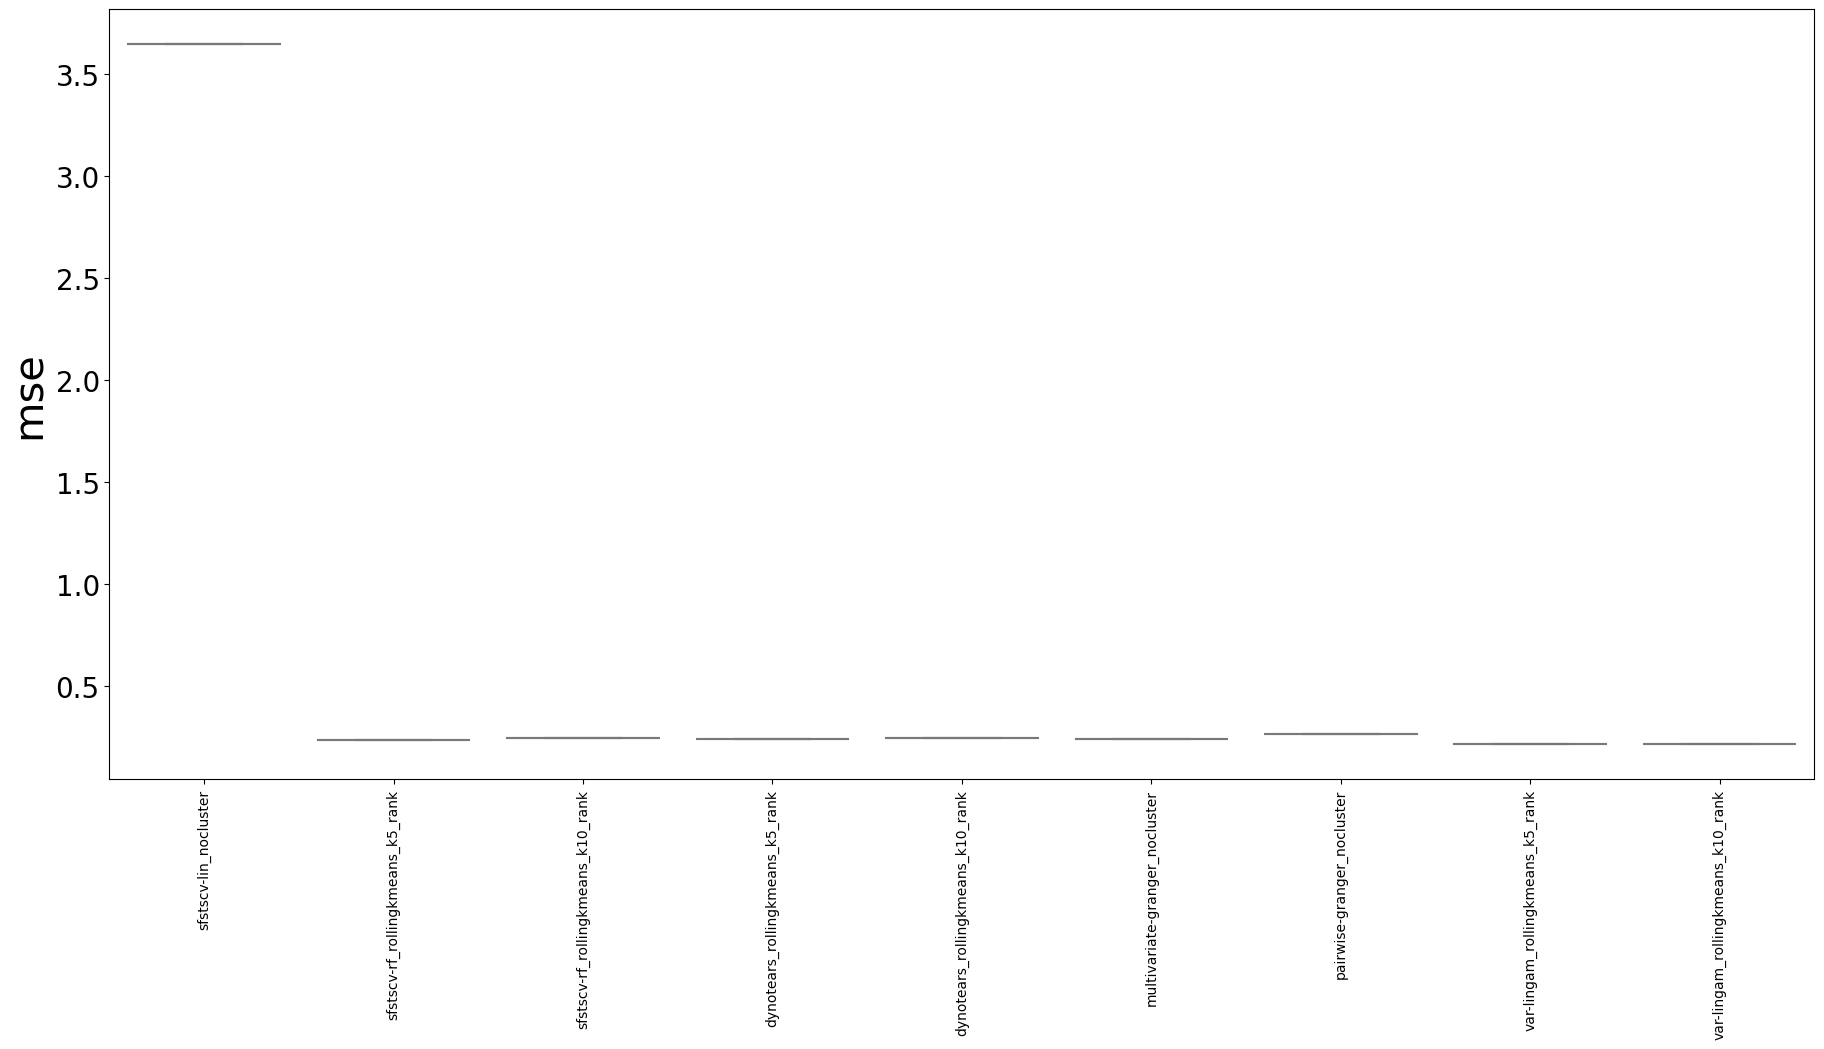

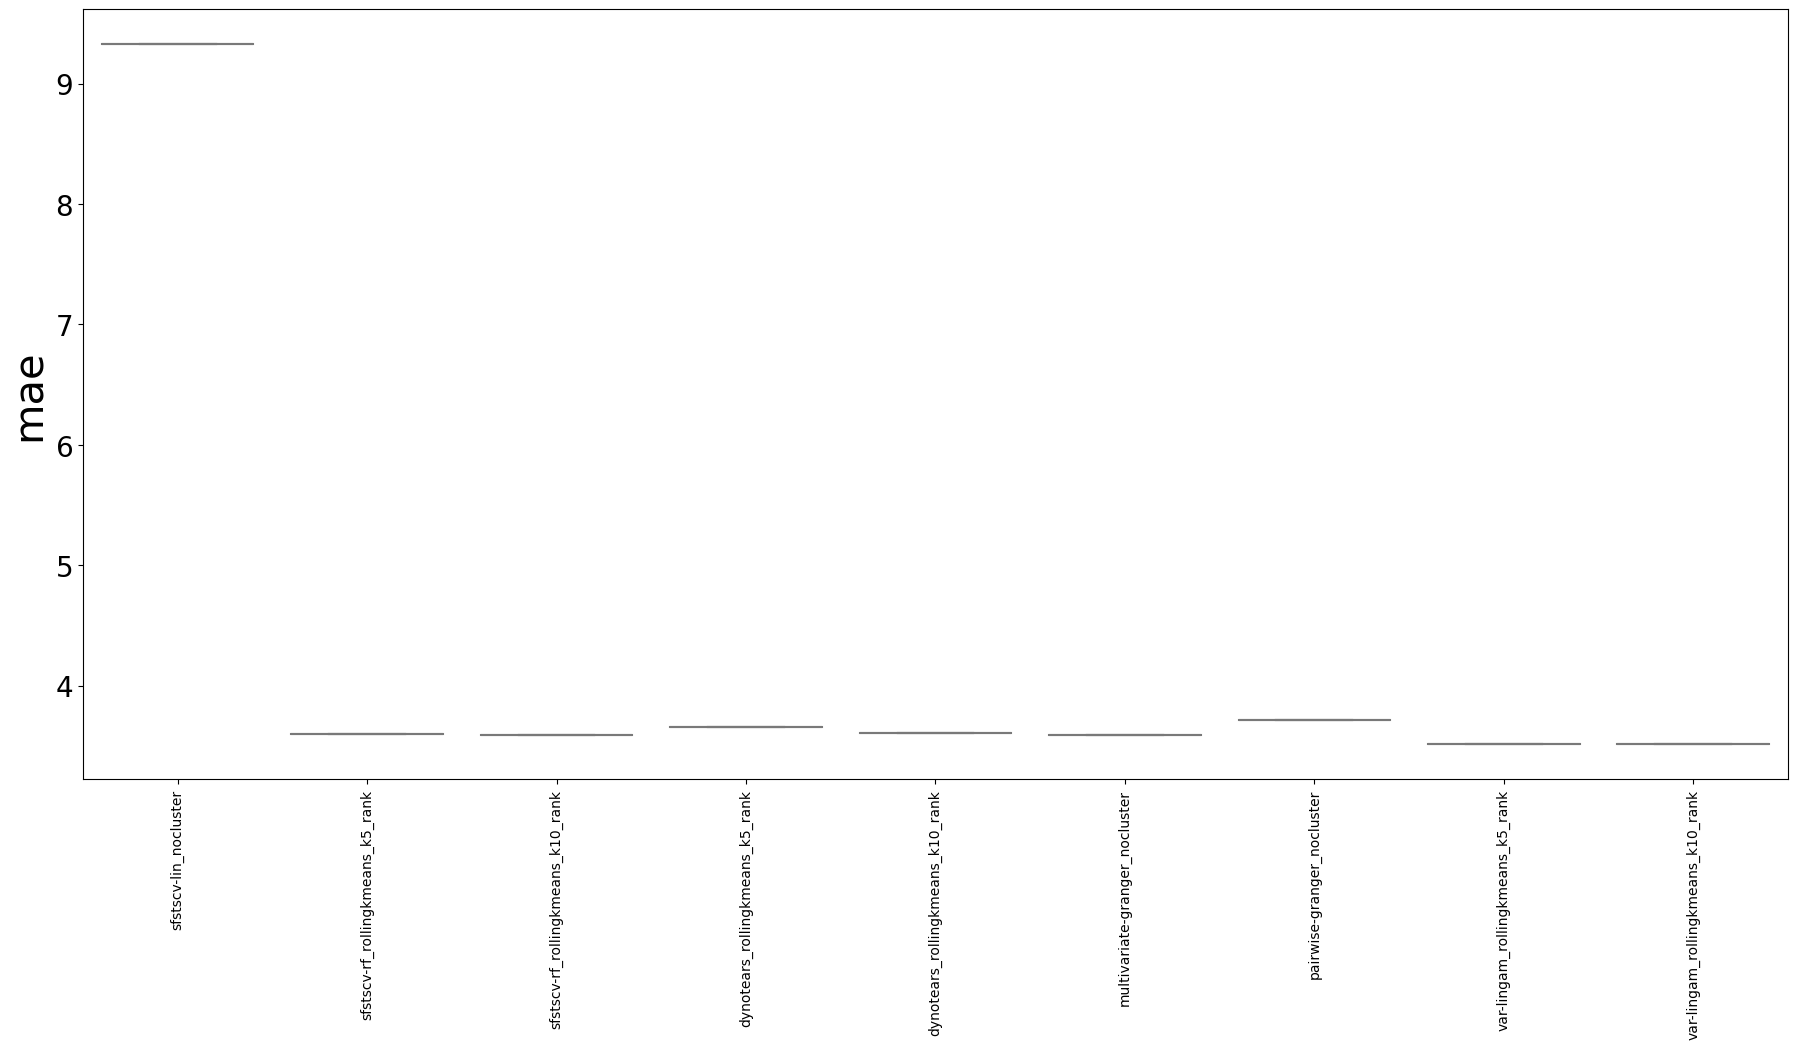

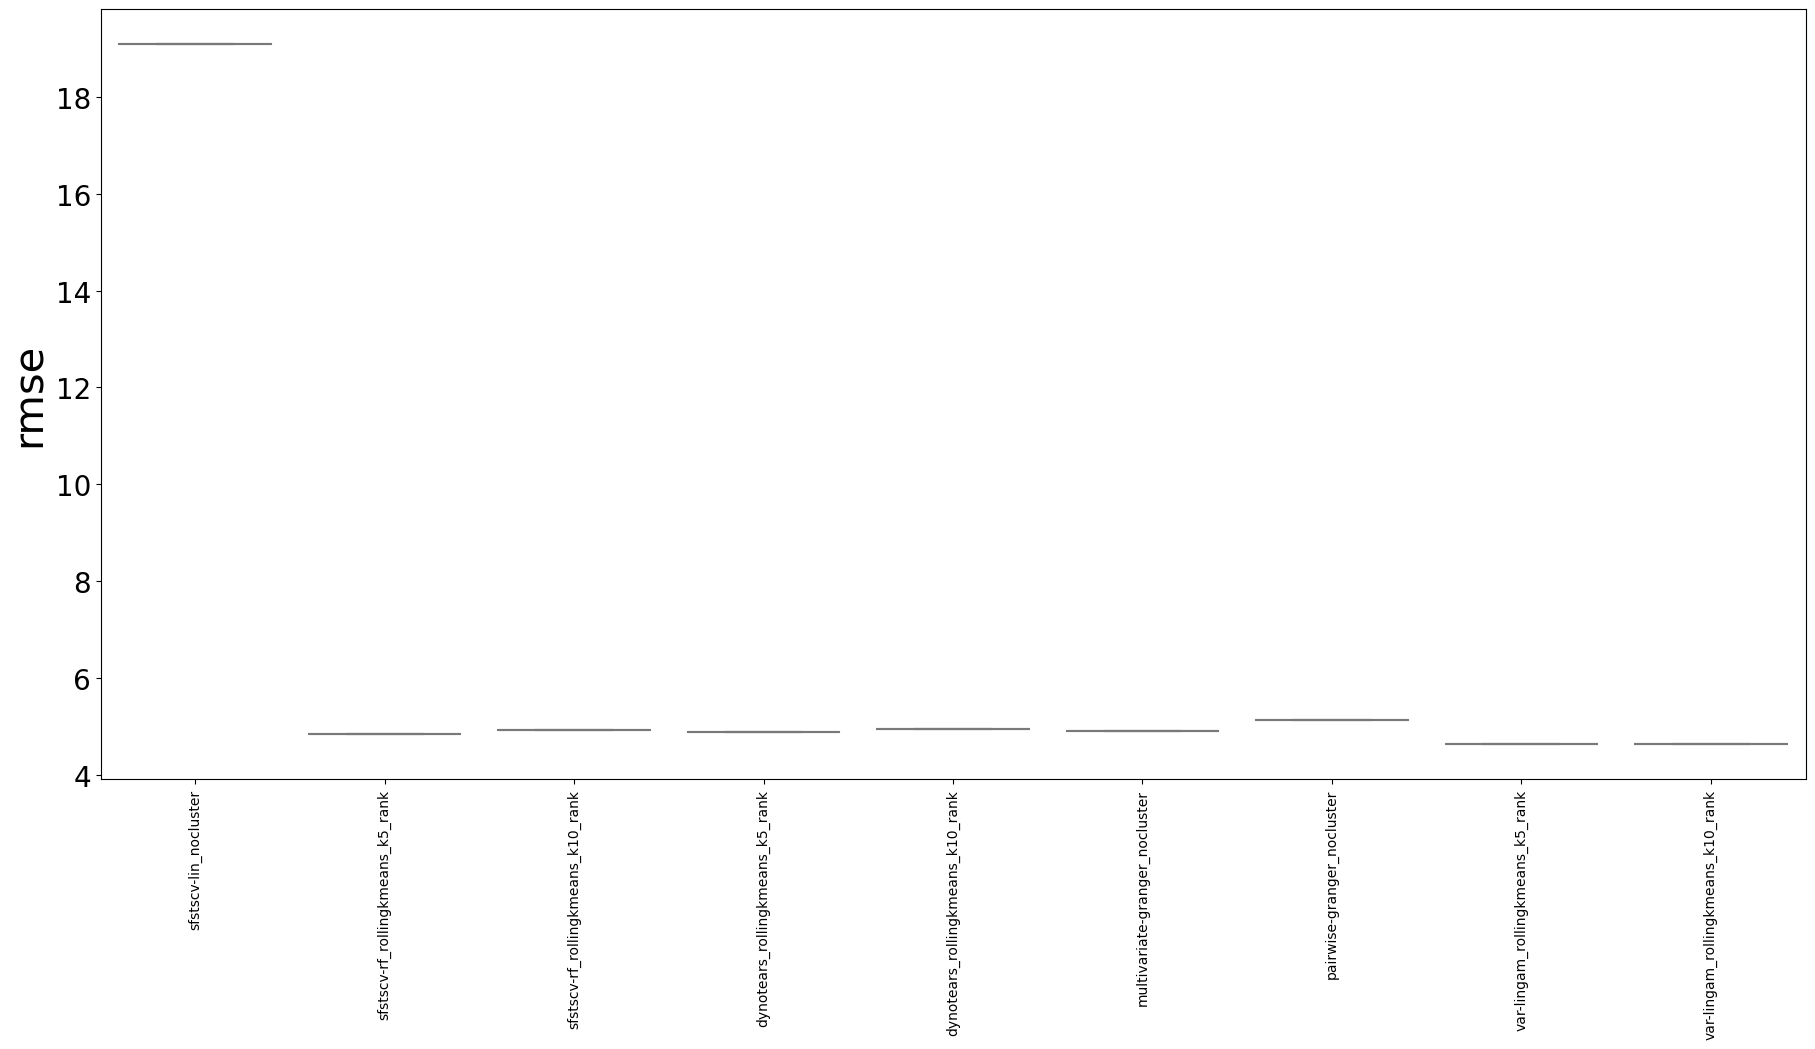

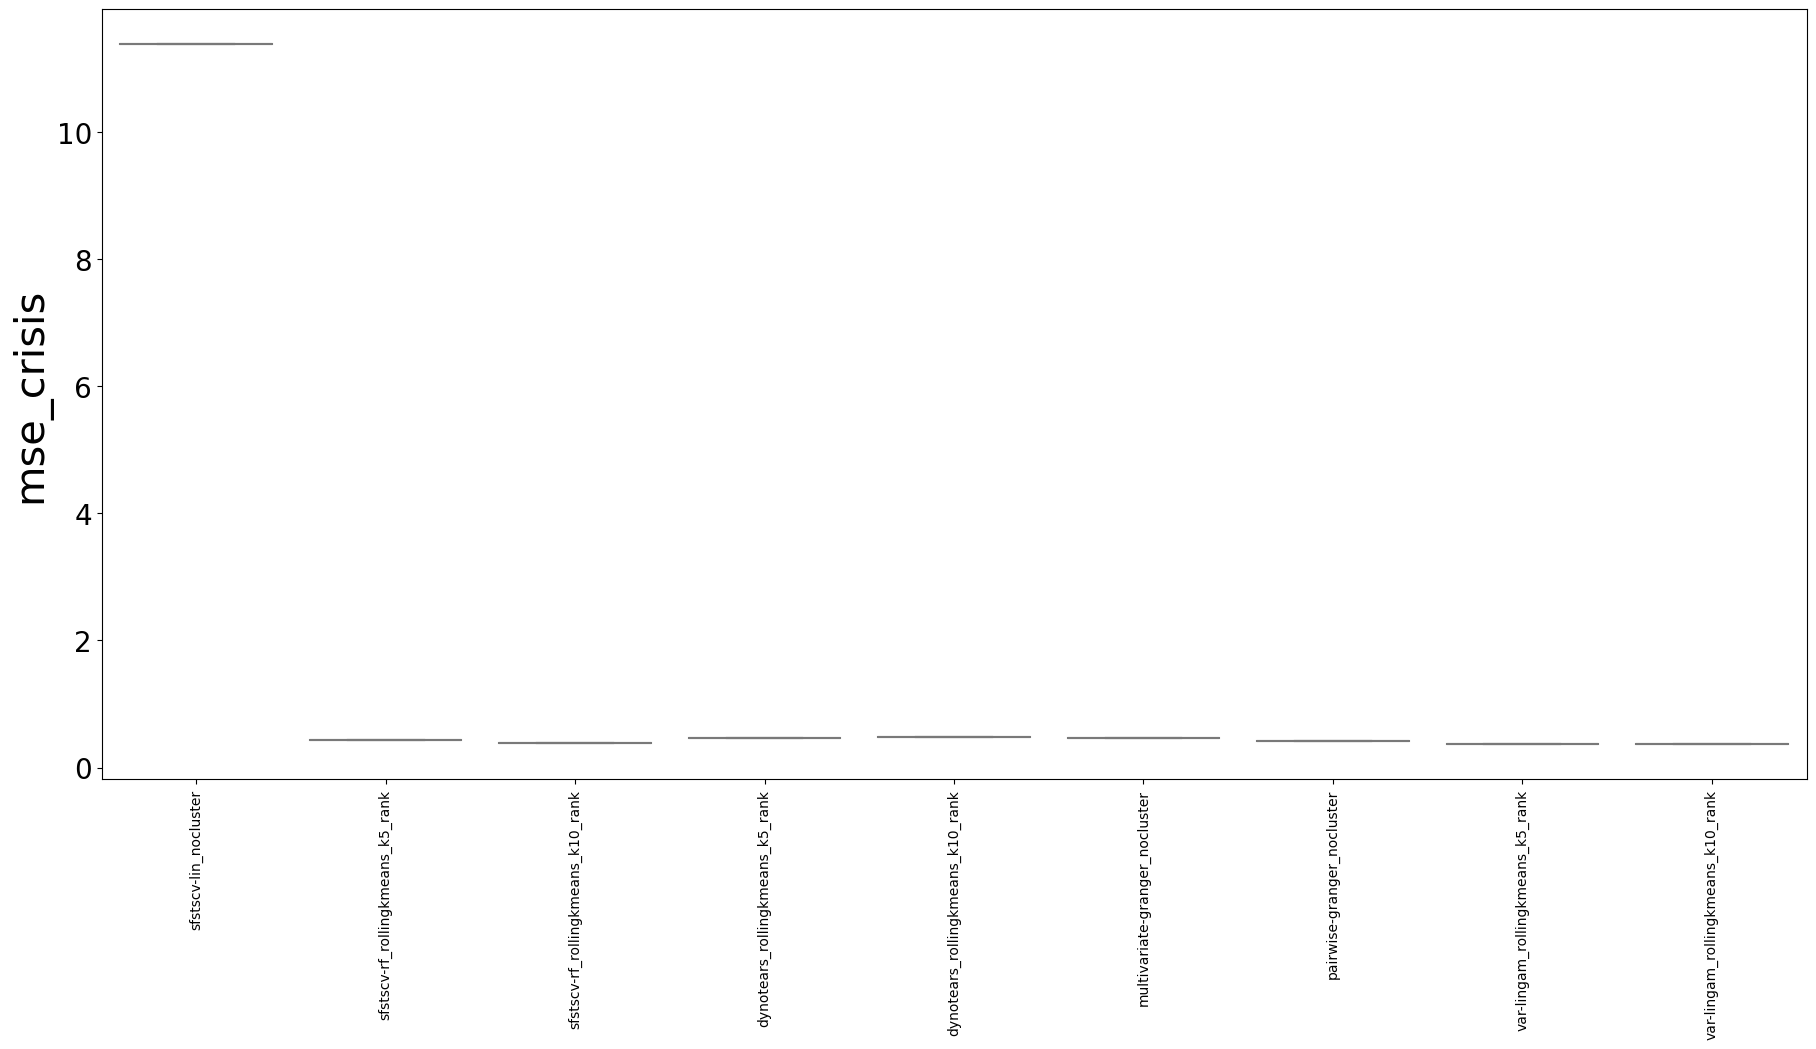

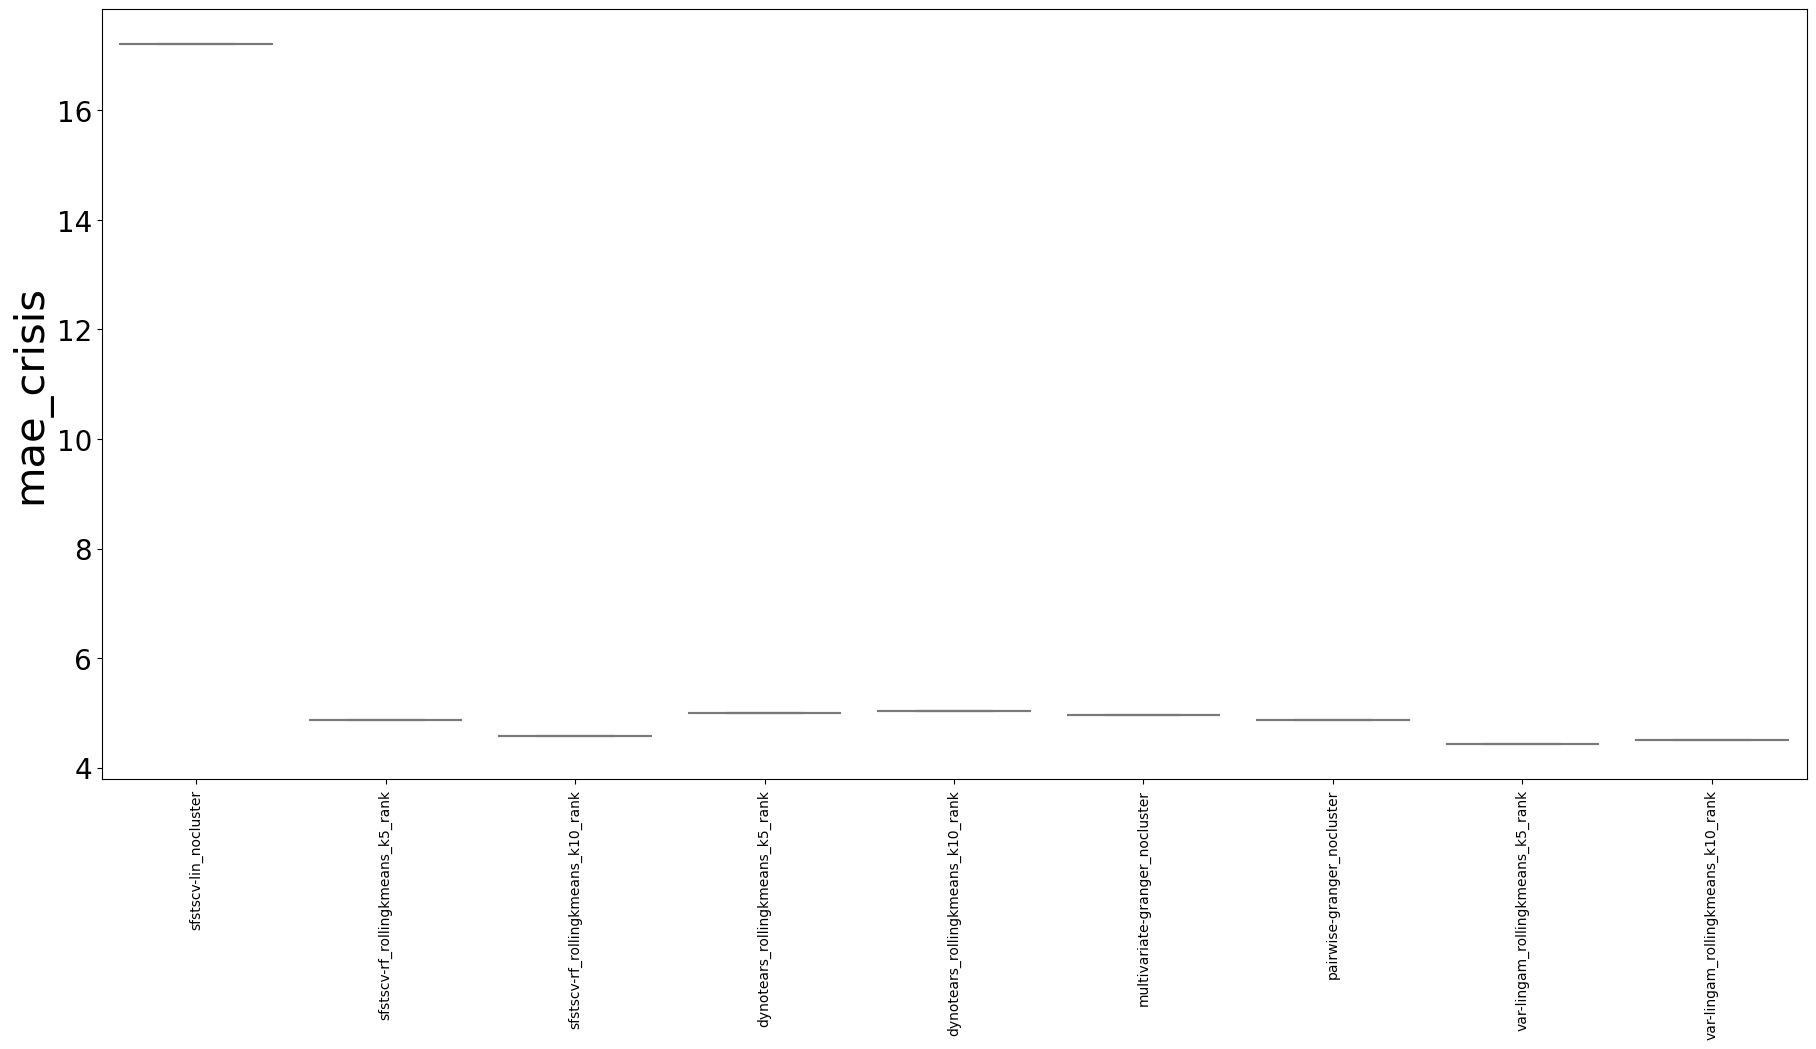

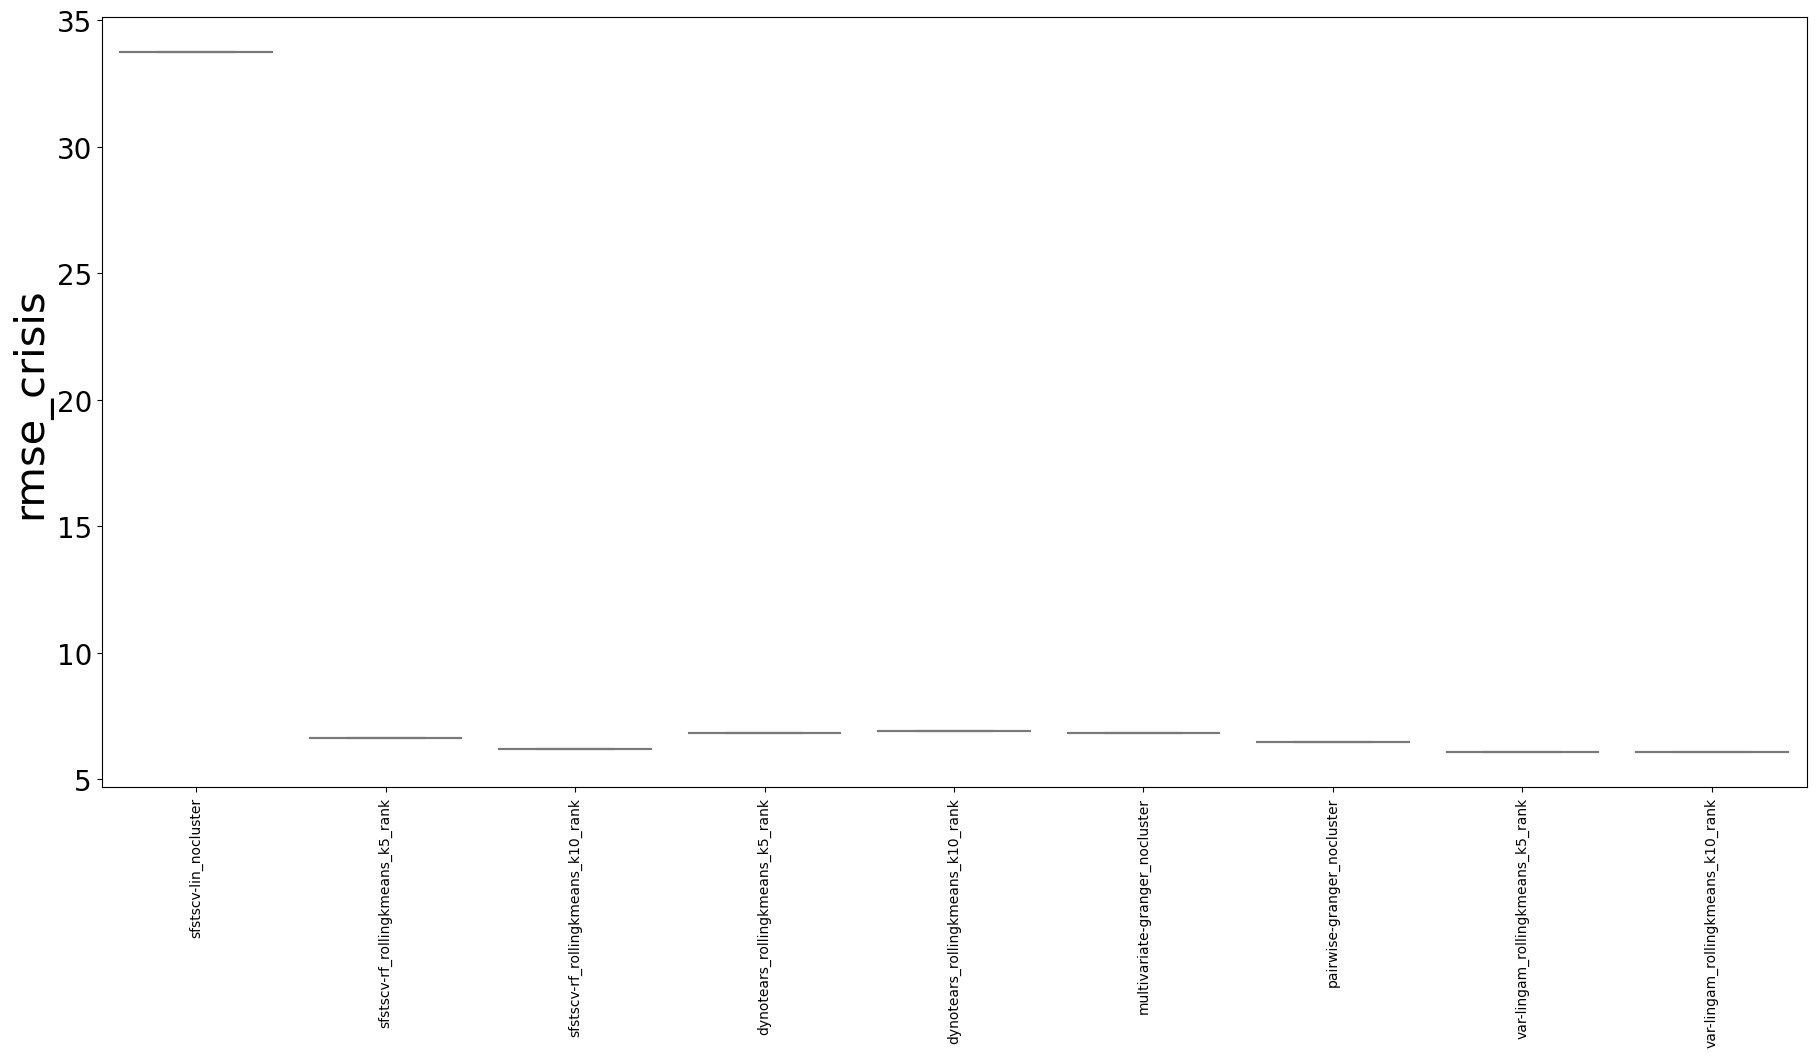

In [19]:
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=10)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

## Prediction error over time

### (a) Rolling MSE

In [80]:
# etf = "XLI"
# selected_models = [
#     "sfstscv_nocluster",
#     "dynotears_nocluster",
#     "pairwise-granger_nocluster",
#     "multivariate-granger_nocluster",
# ]

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_mse.csv"), index=False)

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mae")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_mae.csv"), index=False)

# etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
# etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()

# etf_rolling_metrics_df.reset_index().to_csv(os.path.join(results_path, f"{etf}_rolling_rmse.csv"), index=False)

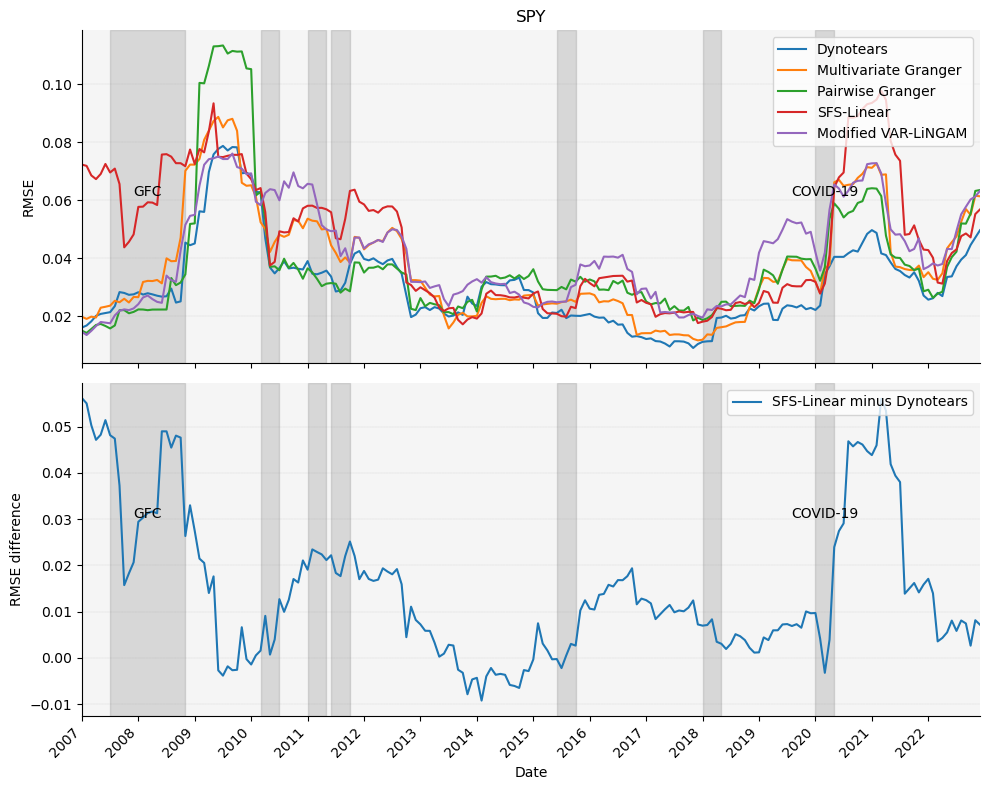

In [87]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "var-lingam_rollingkmeans_k5_rank",
]

rename_fs = {
    "sfstscv-lin_nocluster": "SFS-Linear",
    "dynotears_nocluster": "Dynotears",
    "pairwise-granger_nocluster": "Pairwise Granger",
    "multivariate-granger_nocluster": "Multivariate Granger",
    "var-lingam_rollingkmeans_k5_rank": "Modified VAR-LiNGAM",
}

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    # etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["SFS-Linear minus Dynotears"] = etf_rolling_metrics_df["sfstscv-lin_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]
    etf_rolling_metrics_df = etf_rolling_metrics_df.rename(columns=rename_fs)

    etf_rolling_metrics_df = etf_rolling_metrics_df.loc["2007-01-01":]

     # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["SFS-Linear minus Dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper right')
    axs[0].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[0].set_facecolor('whitesmoke')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    # Plotting on the lower subplot
    etf_rolling_metrics_df["SFS-Linear minus Dynotears"].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')
    axs[1].legend(loc='upper right')
    axs[1].grid(True, axis='y', which='major', linestyle='--', linewidth='0.1', color='gray')
    axs[1].set_facecolor('whitesmoke')
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

    # Add shaded regions for each event
    for event_name, date in event_dates:
        start_date, end_date = date[0], date[1]
        axs[0].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)
        axs[1].axvspan(pd.to_datetime(start_date), pd.to_datetime(end_date), color='grey', alpha=0.25)

         # Check if the event is GFC and add text label
        if (event_name == "GFC") or (event_name == "COVID-19"):
            mid_point = pd.to_datetime(start_date) + (pd.to_datetime(end_date) - pd.to_datetime(start_date)) / 2
            axs[0].text(mid_point, axs[0].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)
            axs[1].text(mid_point, axs[1].get_ylim()[1] * 0.55, event_name, horizontalalignment='center', verticalalignment='top', color='black', fontsize=10)


    # Set x-ticks to yearly frequency, adjust as necessary
    tick_positions = pd.date_range(start=etf_rolling_metrics_df.index.min(), end=etf_rolling_metrics_df.index.max(), freq='AS')
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels([tp.strftime('%Y') for tp in tick_positions], rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mae.png'))

    # Show the plot
    plt.show()

### (b) Rolling RMSE

In [88]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
]

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_rmse")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_sfstscv_dynotears"] = etf_rolling_metrics_df["sfstscv_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_sfstscv_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('RMSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_sfstscv_dynotears"]].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('RMSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_rmse.png'))

    # Show the plot
    plt.show()

KeyError: 'sfstscv_nocluster'

### (c) Rolling MAE

In [89]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

selected_models = [
    "sfstscv_nocluster",
    "dynotears_nocluster",
    "pairwise-granger_nocluster",
    "multivariate-granger_nocluster",
    "var-lingam_rollingkmeans_k5_pca",
]

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mae")&(all_rolling_metrics_df["fs"].isin(selected_models))].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df["diff_sfstscv_dynotears"] = etf_rolling_metrics_df["sfstscv_nocluster"] - etf_rolling_metrics_df["dynotears_nocluster"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_sfstscv_dynotears"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MAE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_sfstscv_dynotears"]].plot(ax=axs[1])
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MAE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mae.png'))

    # Show the plot
    plt.show()

KeyError: 'sfstscv_nocluster'

### (b) Bias-Variance Trade-off

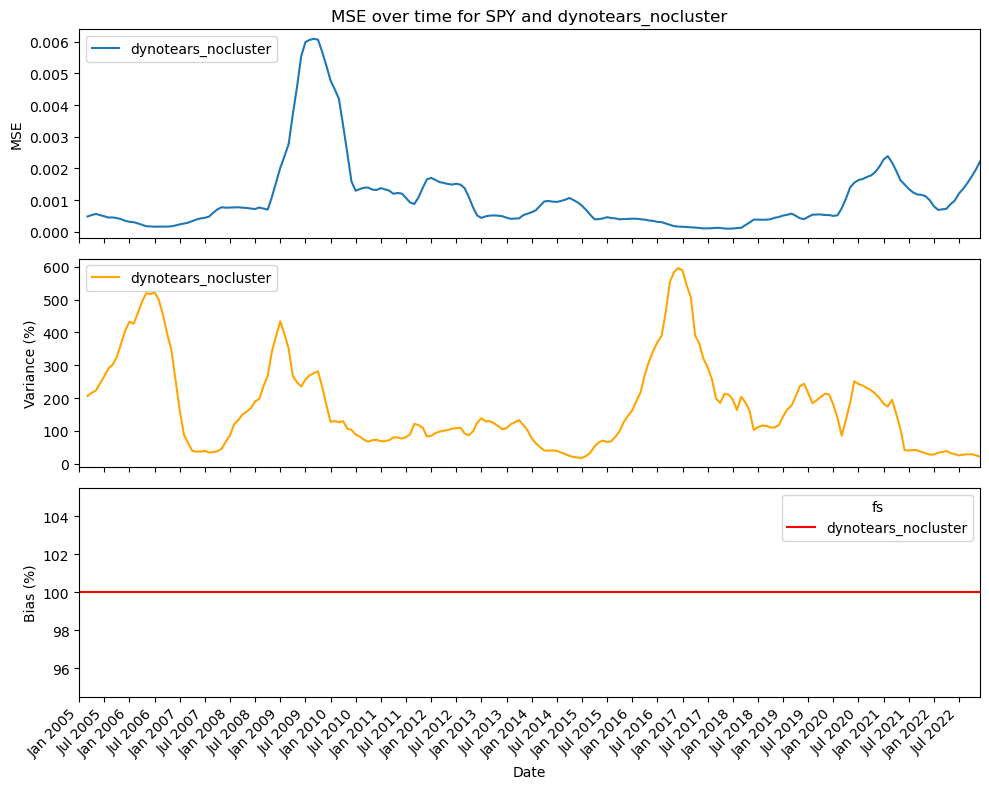

TypeError: no numeric data to plot

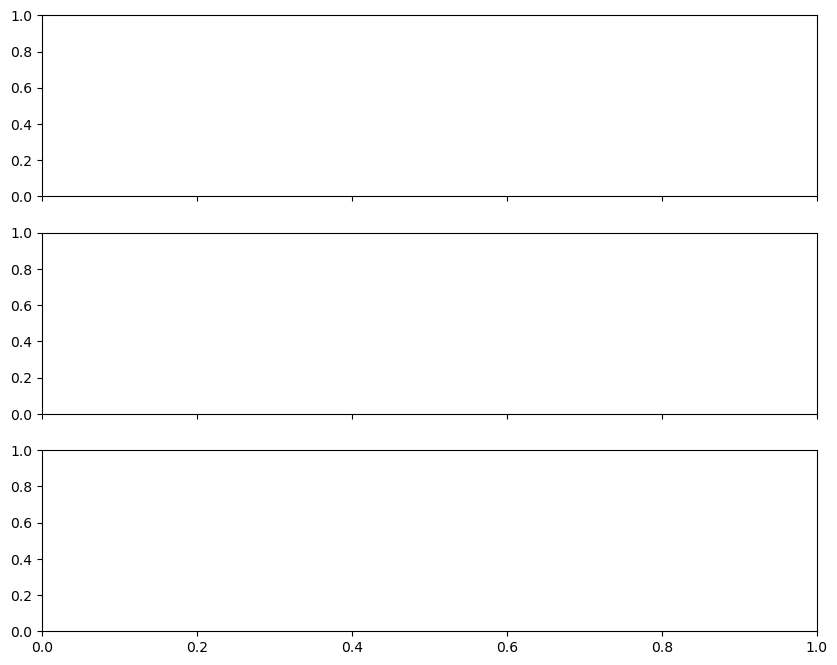

In [90]:
etf = "SPY"
fss = [
    "dynotears_nocluster",
    "sfstscv_nocluster",
    "dynotears_rollingkmeans_k5_pca",
    "sfstscv_rollingkmeans_k5_pca",
]

for fs in fss:
    # mse
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()

    # variance
    etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
    etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
    etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
    etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

    # bias
    etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
    etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
    etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
    etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

    # plotting
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # plotting on the upper subplot
    etf_rolling_metrics_df.plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf} and {fs}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # plotting on the upper subplot
    etf_rolling_variance_df.plot(ax=axs[1], color="orange")
    # axs[1].set_title(f'Variance over time for {etf}')
    axs[1].set_ylabel('Variance (%)')
    axs[1].legend(loc='upper left')

    # plotting on the lower subplot
    etf_rolling_bias_df.plot(ax=axs[2], color="red")
    # axs[2].set_title(f'Bias over time for {etf}')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Bias (%)')

    # adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[2].set_xticks(tick_positions)
    axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Summary Statistics

In [91]:
all_metrics_df.reset_index().groupby("fs").median().sort_values(by="mse", ascending=True)

,mse,mae,rmse,mse_crisis,mae_crisis,rmse_crisis
fs,,,,,,
dynotears_nocluster,0.109421,2.438125,3.307889,0.157342,3.024736,3.966634
multivariate-granger_nocluster,0.166200,2.953717,4.076758,0.306861,3.952038,5.539506
pairwise-granger_nocluster,0.176500,2.853918,4.201193,0.157189,3.068581,3.964713
var-lingam_rollingkmeans_k5_rank,0.185606,3.295448,4.308204,0.266082,3.886637,5.158311
sfstscv-lin_nocluster,16.483814,6.788069,40.600263,0.379807,4.443786,6.162852


In [92]:
all_metrics_df.reset_index().groupby("fs").median().sort_values(by="mse_crisis", ascending=True)

,mse,mae,rmse,mse_crisis,mae_crisis,rmse_crisis
fs,,,,,,
pairwise-granger_nocluster,0.176500,2.853918,4.201193,0.157189,3.068581,3.964713
dynotears_nocluster,0.109421,2.438125,3.307889,0.157342,3.024736,3.966634
var-lingam_rollingkmeans_k5_rank,0.185606,3.295448,4.308204,0.266082,3.886637,5.158311
multivariate-granger_nocluster,0.166200,2.953717,4.076758,0.306861,3.952038,5.539506
sfstscv-lin_nocluster,16.483814,6.788069,40.600263,0.379807,4.443786,6.162852


## Stability Measures

In [93]:
# fred_data = pd.read_csv(os.path.join(os.getcwd(), "data", "inputs", "fredmd_raw.csv"))

# fred_data[['date', 'CUSR0000SAS', 'DPCERA3M086SBEA', 'IPCONGD']].set_index("date").pct_change(12).to_csv(os.path.join(results_path, "SPY_selected_features_YoY.csv"))

In [94]:
etf = "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)

check_df.pivot_table(index=["date"], columns=["fred"], values=["value"]).loc["2006-01-01":"2008-01-01"].dropna(axis=1, how="all").sum(axis=0).sort_values(ascending=False)

       fred         
value  BOGMBASE         25.0
       CLAIMSx          25.0
       CUSR0000SAS      25.0
       GS10             25.0
       M2SL             25.0
       S&P div yield    25.0
       SPY              25.0
       PERMITW          16.0
       HWI               5.0
       IPCONGD           4.0
       IPFINAL           4.0
       TOTRESNS          4.0
       ACOGNO            3.0
       AAA               1.0
dtype: float64

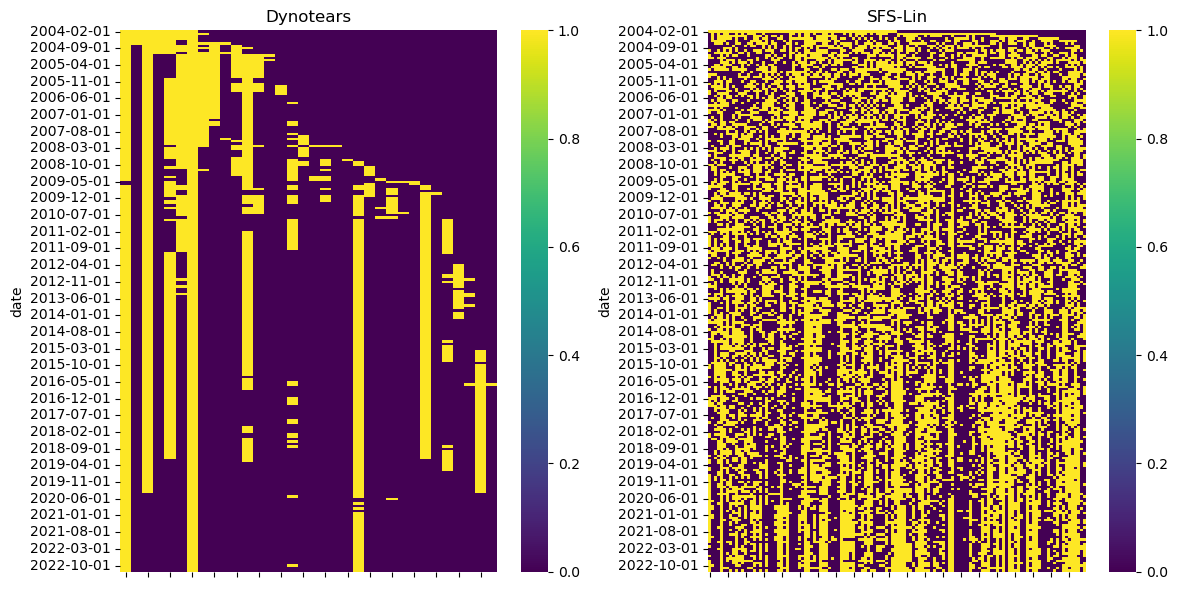

In [95]:
# Create a figure with 2 subplots (side by side)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot the first heatmap
etf = "SPY"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[0], cmap="viridis")
axs[0].set_title('Dynotears')

# Plot the second heatmap
etf = "SPY"
fs = "sfstscv-lin_nocluster"
check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]
pivot_table_data = check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0)

pivot_table_data.columns = pivot_table_data.columns.droplevel()
pivot_table_data.columns = ["" for col in pivot_table_data.columns]

sns.heatmap(pivot_table_data, ax=axs[1], cmap="viridis")
axs[1].set_title('SFS-Lin')

# Adjust layout
plt.tight_layout()

# save plot
fig.savefig(os.path.join(results_path, 'compare_clusters_heatmap.png'))

In [96]:
etf = "XLI"
fs = "dynotears_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(11, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1100x900 with 0 Axes>

In [97]:
etf = "SPY"
fs = "sfstscv_nocluster"

check_df = all_parents_df.loc[(all_parents_df['etf'] == etf)&(all_parents_df['fs'] == fs)].drop(["etf", "fs"], axis=1)
check_df["date"] = [pd.to_datetime(dtref).strftime('%Y-%m-%d') for dtref in check_df["date"]]

plt.figure(figsize=(11, 9))
sns.heatmap(check_df.pivot_table(index=["date"], columns=["cluster"], values=["value"]).fillna(0))

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1100x900 with 0 Axes>

In [53]:
# pivot_all_etfs_scores_df.reset_index().to_csv(os.path.join(results_path, "stability_df.csv"), index=False)

<AxesSubplot:xlabel='date'>

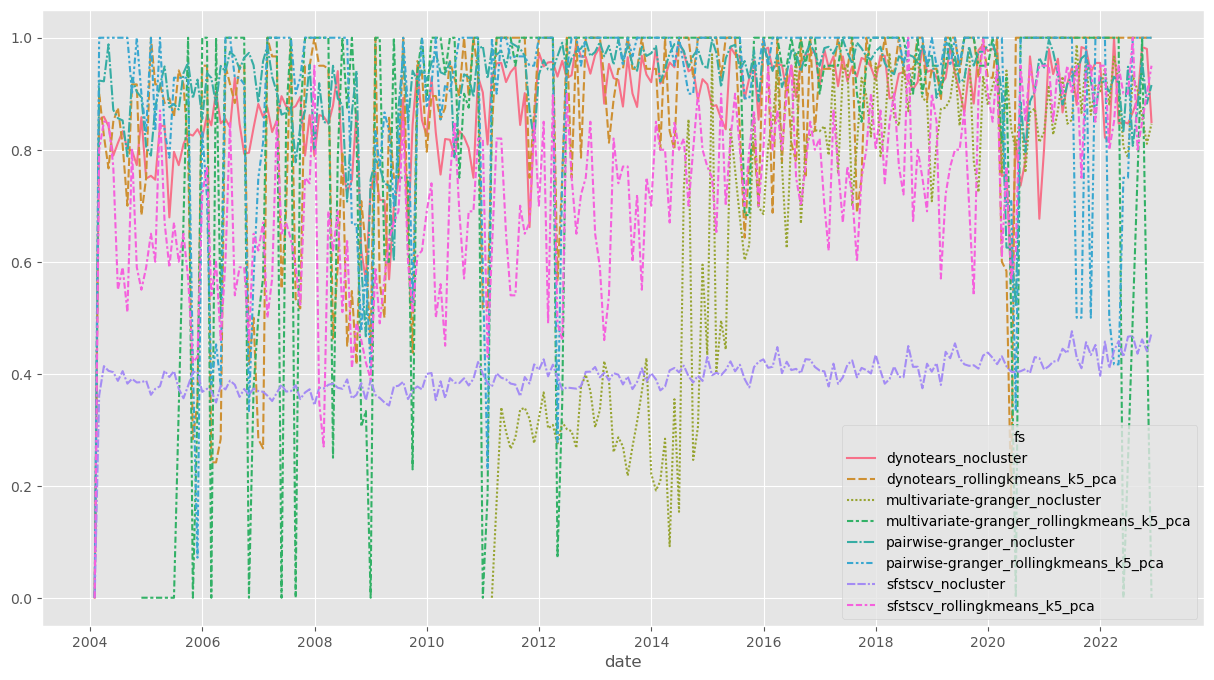

In [48]:
pivot_all_etfs_scores_df = all_etfs_scores_df.pivot_table(index=["date"], columns=["fs"], values=["value"])
pivot_all_etfs_scores_df.columns = pivot_all_etfs_scores_df.columns.droplevel(0)
pivot_all_etfs_scores_df.index = pd.to_datetime(pivot_all_etfs_scores_df.index)

plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df)

<AxesSubplot:xlabel='date'>

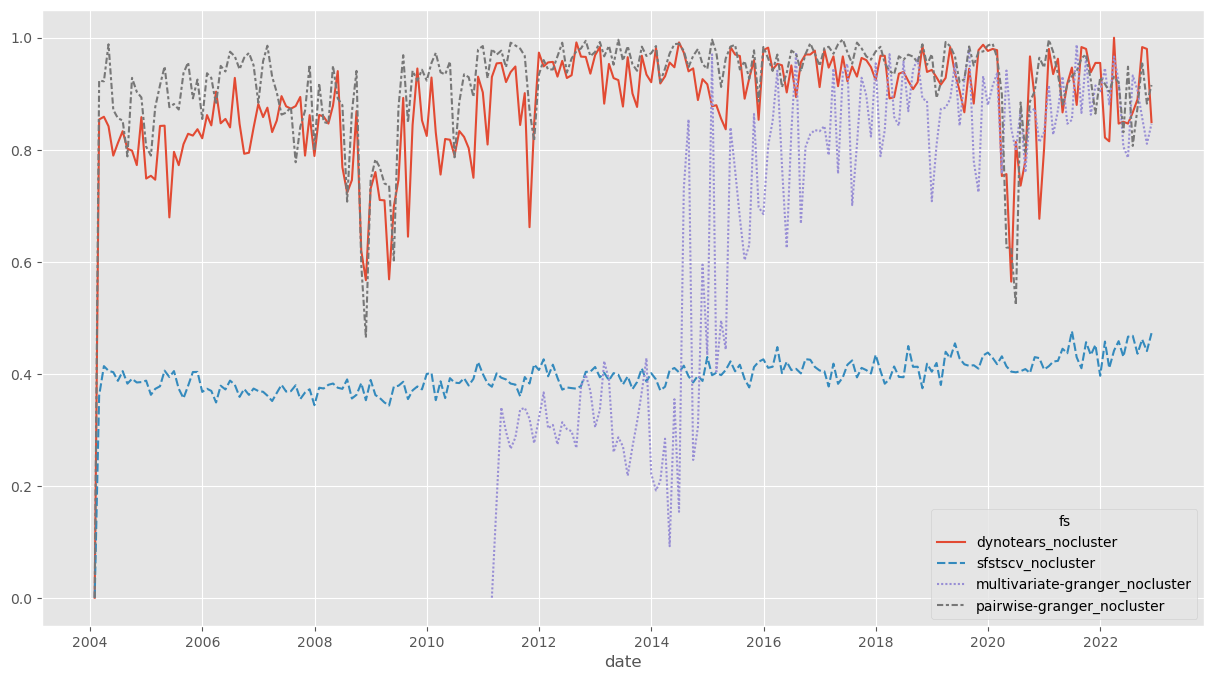

In [30]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=pivot_all_etfs_scores_df[["dynotears_nocluster", "sfstscv_nocluster", "multivariate-granger_nocluster", "pairwise-granger_nocluster"]])